# Final Project Submission

- Student name: Sue Lim
- Scheduled project review date/time: July 21, 2023, 11:00 AM - 11:45 AM

# I. Import YouTube Data & Cleaning

In this section, I import pre-pulled YouTube data containing titles, descriptions, and tags for more than 5,000 videos, and clean the data in the following ways to make it ready for training:

1. Create a new field "text" which combines a video's title, description, and tags.
2. Standardize the words in the text field by converting them to lower case and lemmatizing them.
3. Limit the data to videos in English.
4. Downsample from the majority class "False" for the target variable "madeForKids" to handle the class imbalance issue.
5. Create a bag of words using the standardized text.

As the first step, I import various packages and YouTube data.

In [1]:
import os
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors
import pandas as pd
import numpy as np
import re
import string
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from langdetect import detect
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.concat([pd.read_excel('Data/data1.xlsx', index_col = 0), \
                  pd.read_excel('Data/data2.xlsx', index_col = 0), \
                  pd.read_excel('Data/data3.xlsx', index_col = 0), \
                  pd.read_excel('Data/data4.xlsx', index_col = 0)], axis = 0).reset_index(drop = True)

After importing the YouTube data, I convert titles, descriptions, and tags to lowercase and concatenate them as a new field "text".

In [2]:
data['text'] = data['title'] + ' ' + data['description'].map(lambda x: ' '.join(x.split()) if x is not np.nan else '') + \
data['tags'].map(lambda x: ' '.join(x.split()) if x is not np.nan else '')
data['text'] = data['text'].map(lambda x: x.lower())

Then, I limit the data only to the videos in English, as that is the language that I want to focus on, and data in other languages could become noise for training models.

In [3]:
# Use the detect function of the package "langdetect"

data['lang'] = None
for index in data.index:
    try:
        data['lang'][index] = detect(data['text'][index])
    except:
        data['lang'][index] = 'other'
# data = data[(data['lang'] == 'en')]        
data = data[(data['lang'] == 'en') | (data['defaultAudioLanguage'].str.startswith("en") == True)]

<ipython-input-3-77ac0d62ca83>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lang'][index] = detect(data['text'][index])
<ipython-input-3-77ac0d62ca83>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lang'][index] = 'other'


As seen below, there is a class imbalance issue. There are only 214 videos that were made for kids, whereas 4,254 videos were not made for them. For this reason, I downsample the data so that there is the same number of videos made for kids vs not made for kids.

In [4]:
data['madeForKids'].value_counts()

False    4251
True      214
Name: madeForKids, dtype: int64

As a result, I end up with 428 videos to train classification models.

In [5]:
madeForKids = data[data['madeForKids'] == True]
notMadeForKids = data[data["madeForKids"] == False].sample(round(len(madeForKids) * 1.0))
data_final = pd.concat([notMadeForKids, madeForKids], axis = 0)
data_final['madeForKids'].value_counts()

True     214
False    214
Name: madeForKids, dtype: int64

The final step involves creating a bag of words, after cleaning words in text by 1) removing a set of commonly used words that do not have special meaning to indicate whether a video was made for kids or not, and 2) lemmatizing the words. Lemmatizing is a process of grouping inflected forms of words as single terms. For example, both "loved" and "loves" are grouped as the word "love".

In [6]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def bag_it(text):
    bag = {}
    for word in text.split(): 
        word_clean = lemmatizer.lemmatize(re.sub('\W+','', word))
        if word not in stop_words and word_clean != '' and word_clean.isalpha():
            bag[word_clean] = bag.get(word_clean, 0) + 1
    return bag

I create a bag of words for both the whole dataset and the sampled dataset. This is because, while I will use the sampled dataset for training, I plan to use the whole dataset as the final validationd dataset. A bag of words is a dataset with frequency for each word from a word universe for given example text.

In [7]:
# Create a bag of words for the whole dataset

docs = []
for doc in data['text']:
    docs.append(bag_it(doc))

features = pd.DataFrame.from_dict(docs)
features = features.replace(np.nan, 0)

In [8]:
# Create a bag of words for the sampled dataset

docs = []
for doc in data_final['text']:
    docs.append(bag_it(doc))

features_final = pd.DataFrame.from_dict(docs)
features_final = features_final.replace(np.nan, 0)

# II. Training Models to Predict Whether a Video was Made for Kids

In this section, I train the following models and choose the best model to predict if a video was made for kids or not:

1. Gradient Boosting
2. AdaBoost
3. Naive Bayes
4. XGBoost

In training the models, I use grid search to find the best paramters based on the accuracy score. In deciding which model performs the best, I use 1) accuracy score using training data; 2) accuracy score using test data; and 3) accuracy score using the whole dataset. 

Accuracy score using training data shows how well the model is able to capture information from the training data, and accuracy score using test data shows how well the model can be generalized to other data. Finally, accuracy score using the whole dataset shows how well the model predicts in the context of the actual distribution of the videos made for kids vs not made for kids. Specifically, I assess if a model can identify videos made for kids, while not flagging too many videos not made for kids, as made for kids, using confusion matrix.

As the first step, I split the sampled data into a training dataset using (75% of the videos) and a test dataset (25% of the videos).

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features_final, data_final['madeForKids'], 
                                                    stratify = data_final['madeForKids'], 
                                                    random_state = 888)

In the following steps, I train each model, and calculate accuracy scores using training data, test data, and the whole dataset. I also analyze the breakdown of the accuracy score for the whole dataset, and this step is important because we do not want to pick a model as the best one if accuracy score is high because it flags most videos as not made for kids (as it is the majority class), and does not really identify videos made for kids correctly.

Grid Search found the following optimal parameters: 
learning_rate: 0.15

Training Accuracy: 99.69%


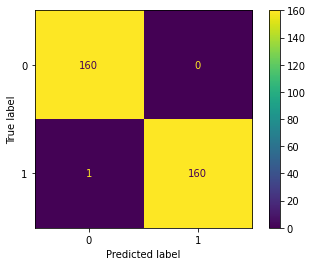


Validation Accuracy: 93.46%


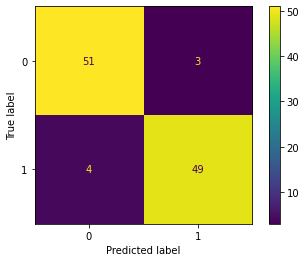


Validation Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.94      0.94        54
        True       0.94      0.92      0.93        53

    accuracy                           0.93       107
   macro avg       0.93      0.93      0.93       107
weighted avg       0.93      0.93      0.93       107


Entire Data Accuracy: 93.86%


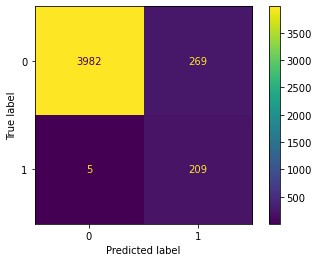

In [10]:
# Model 1: Gradient Boosting

gb = GradientBoostingClassifier()
grid_gb = GridSearchCV(gb, {'learning_rate': [0.05, 0.1, 0.15]}, scoring='accuracy', cv = 3, n_jobs = 1)
grid_gb.fit(X_train, y_train)

best_parameters = grid_gb.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_accuracy = accuracy_score(y_train, grid_gb.predict(X_train))
test_accuracy = accuracy_score(y_test, grid_gb.predict(X_test))
entire_data_preds = grid_gb.predict(features[list(X_train.columns)])
entire_data_accuracy = accuracy_score(data['madeForKids'], entire_data_preds)

print('\nTraining Accuracy: {:.4}%'.format(training_accuracy * 100))
confusion_matrix_train = ConfusionMatrixDisplay(confusion_matrix(y_train, grid_gb.predict(X_train)))
confusion_matrix_train.plot()
plt.show()
print('\nValidation Accuracy: {:.4}%'.format(test_accuracy * 100))
confusion_matrix_test = ConfusionMatrixDisplay(confusion_matrix(y_test, grid_gb.predict(X_test)))
confusion_matrix_test.plot()
plt.show()
print('\nValidation Classification Report:\n' + classification_report(y_test, grid_gb.predict(X_test)))
print('\nEntire Data Accuracy: {:.4}%'.format(entire_data_accuracy * 100))
confusion_matrix_entire = ConfusionMatrixDisplay((confusion_matrix(data['madeForKids'], entire_data_preds)))
confusion_matrix_entire.plot();

Grid Search found the following optimal parameters: 
learning_rate: 0.35

Training Accuracy: 94.7%


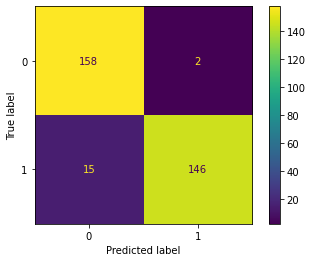


Validation Accuracy: 88.79%


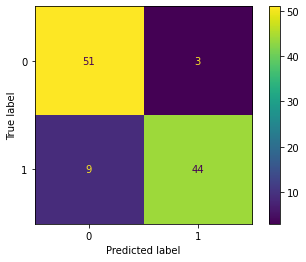


Validation Classification Report:
              precision    recall  f1-score   support

       False       0.85      0.94      0.89        54
        True       0.94      0.83      0.88        53

    accuracy                           0.89       107
   macro avg       0.89      0.89      0.89       107
weighted avg       0.89      0.89      0.89       107


Entire Data Accuracy: 88.53%


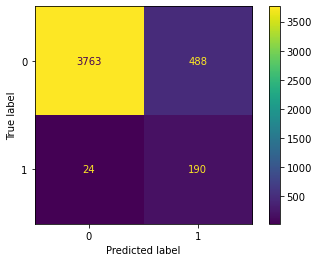

In [11]:
# Model 2: AdaBoost

ab = AdaBoostClassifier()
grid_ab = GridSearchCV(ab, {'learning_rate': [0.35, 0.4, 0.45]}, scoring='accuracy', cv = 3, n_jobs = 1)
grid_ab.fit(X_train, y_train)

best_parameters = grid_ab.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_accuracy = accuracy_score(y_train, grid_ab.predict(X_train))
test_accuracy = accuracy_score(y_test, grid_ab.predict(X_test))
entire_data_preds = grid_ab.predict(features[list(X_train.columns)])
entire_data_accuracy = accuracy_score(data['madeForKids'], entire_data_preds)

print('\nTraining Accuracy: {:.4}%'.format(training_accuracy * 100))
confusion_matrix_train = ConfusionMatrixDisplay(confusion_matrix(y_train, grid_ab.predict(X_train)))
confusion_matrix_train.plot()
plt.show()
print('\nValidation Accuracy: {:.4}%'.format(test_accuracy * 100))
confusion_matrix_test = ConfusionMatrixDisplay(confusion_matrix(y_test, grid_ab.predict(X_test)))
confusion_matrix_test.plot()
plt.show()
print('\nValidation Classification Report:\n' + classification_report(y_test, grid_ab.predict(X_test)))
print('\nEntire Data Accuracy: {:.4}%'.format(entire_data_accuracy * 100))
confusion_matrix_entire = ConfusionMatrixDisplay((confusion_matrix(data['madeForKids'], entire_data_preds)))
confusion_matrix_entire.plot();

Grid Search found the following optimal parameters: 
alpha: 0.01

Training Accuracy: 100.0%


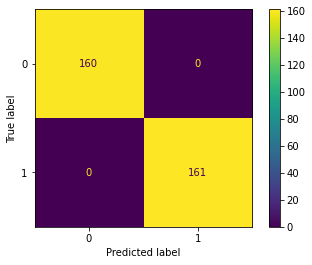


Validation Accuracy: 93.46%


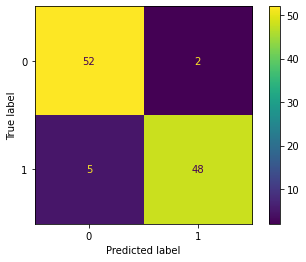


Validation Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.96      0.94        54
        True       0.96      0.91      0.93        53

    accuracy                           0.93       107
   macro avg       0.94      0.93      0.93       107
weighted avg       0.94      0.93      0.93       107


Entire Data Accuracy: 93.77%


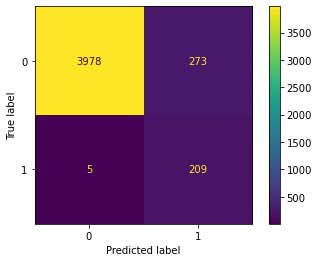

In [12]:
# Model 3: Naive Bayes

nb = MultinomialNB()
grid_nb = GridSearchCV(nb, {'alpha': [0.001, 0.01, 0.05, 0.1]}, scoring='accuracy', cv = 3, n_jobs = 1)
grid_nb.fit(X_train, y_train)

best_parameters = grid_nb.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_accuracy = accuracy_score(y_train, grid_nb.predict(X_train))
test_accuracy = accuracy_score(y_test, grid_nb.predict(X_test))
entire_data_preds = grid_nb.predict(features[list(X_train.columns)])
entire_data_accuracy = accuracy_score(data['madeForKids'], entire_data_preds)

print('\nTraining Accuracy: {:.4}%'.format(training_accuracy * 100))
confusion_matrix_train = ConfusionMatrixDisplay(confusion_matrix(y_train, grid_nb.predict(X_train)))
confusion_matrix_train.plot()
plt.show()
print('\nValidation Accuracy: {:.4}%'.format(test_accuracy * 100))
confusion_matrix_test = ConfusionMatrixDisplay(confusion_matrix(y_test, grid_nb.predict(X_test)))
confusion_matrix_test.plot()
plt.show()
print('\nValidation Classification Report:\n' + classification_report(y_test, grid_nb.predict(X_test)))
print('\nEntire Data Accuracy: {:.4}%'.format(entire_data_accuracy * 100))
confusion_matrix_entire = ConfusionMatrixDisplay((confusion_matrix(data['madeForKids'], entire_data_preds)))
confusion_matrix_entire.plot();

Grid Search found the following optimal parameters: 
learning_rate: 0.55

Training Accuracy: 97.82%


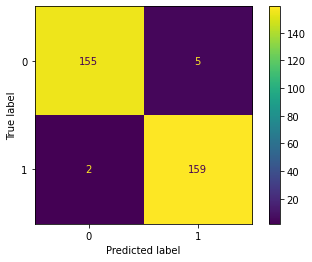


Validation Accuracy: 82.24%


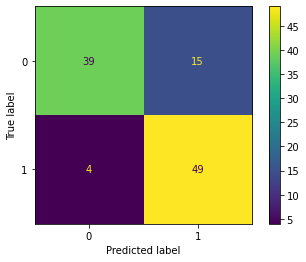


Validation Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.72      0.80        54
        True       0.77      0.92      0.84        53

    accuracy                           0.82       107
   macro avg       0.84      0.82      0.82       107
weighted avg       0.84      0.82      0.82       107


Entire Data Accuracy: 80.18%


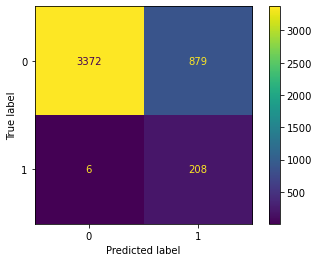

In [13]:
# Model 4: XGBoost

xg = XGBClassifier()
grid_xg = GridSearchCV(xg, {'learning_rate': [0.5, 0.55, 0.6]}, scoring='accuracy', cv = 3, n_jobs = 1)
grid_xg.fit(X_train, y_train)

best_parameters = grid_xg.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_accuracy = accuracy_score(y_train, grid_xg.predict(X_train))
test_accuracy = accuracy_score(y_test, grid_xg.predict(X_test))
entire_data_preds = grid_xg.predict(features[list(X_train.columns)])
entire_data_accuracy = accuracy_score(data['madeForKids'], entire_data_preds)

print('\nTraining Accuracy: {:.4}%'.format(training_accuracy * 100))
confusion_matrix_train = ConfusionMatrixDisplay(confusion_matrix(y_train, grid_xg.predict(X_train)))
confusion_matrix_train.plot()
plt.show()
print('\nValidation Accuracy: {:.4}%'.format(test_accuracy * 100))
confusion_matrix_test = ConfusionMatrixDisplay(confusion_matrix(y_test, grid_xg.predict(X_test)))
confusion_matrix_test.plot()
plt.show()
print('\nValidation Classification Report:\n' + classification_report(y_test, grid_xg.predict(X_test)))
print('\nEntire Data Accuracy: {:.4}%'.format(entire_data_accuracy * 100))
confusion_matrix_entire = ConfusionMatrixDisplay((confusion_matrix(data['madeForKids'], entire_data_preds)))
confusion_matrix_entire.plot();

Based on the information printed above, I pick the model using Naive Bayes. It has the highest validation accuracy and entire data accuracy. Below are top 30 words for kids videos and non-kids videos.

In [14]:
nb = MultinomialNB(alpha = 0.01)
nb.fit(X_train, y_train)

pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()[::-1]
neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()[::-1]

print("Top 30 Keywords for Kids Videos:\n" + str(np.take(list(X_train.columns), pos_class_prob_sorted[:30])))
print("\n")
print("Top 30 Keywords for Non-Kids Videos:\n" + str(np.take(list(X_train.columns), neg_class_prob_sorted[:30])))

Top 30 Keywords for Kids Videos:
['kid' 'song' 'miraculous' 'mickey' 'animation' 'use' 'video' 'ladybug'
 'on' 'mouse' 'baby' 'noir' 'copyright' 'fair' 'day' 'english' 'episode'
 'season' 'go' 'rhyme' 'child' 'helper' 'nursery' 'under' 'fun' 'in'
 'adventure' 'de' 'clubhouse' 'friend']


Top 30 Keywords for Non-Kids Videos:
['video' 'new' 'movie' 'u' 'game' 'tool' 'scene' 'channel' 'subscribe'
 'best' 'live' 'क' 'story' 'use' 'news' 'top' 'life' 'jokic' 'world'
 'instagram' 'nikola' 'make' 'india' 'destiny' 'home' 'music' 'goku'
 'fight' 'facebook' 'ह']


# III. Additional Tests

In this section, I run some additional tests to see if the best model using Naive Bayes is indeed able to predict the type of videos accurately. For this exercise, I pulled top 4 videos made for kids in a search result and saw if the model predicts the right class. I also add predictions from Gradient Boosting for comparison.

In [15]:
# Get credentials and create an API client

scopes = ["https://www.googleapis.com/auth/youtube.force-ssl"]

os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

api_service_name = "youtube"
api_version = "v3"
client_secrets_file = "../work/YOUR_CLIENT_SECRET_FILE.json"

flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(client_secrets_file, scopes)
credentials = flow.run_local_server()
youtube = googleapiclient.discovery.build(api_service_name, api_version, credentials = credentials)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=138378474782-vjv918m0tiptts1i8hk4ip7jkqjh7sdr.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.force-ssl&state=aN6op2EIt48acpa3GuGVF4h0mwklrN&access_type=offline


In [16]:
# Video 1

test = youtube.videos().list(part = 'id,snippet,status', id = '9_WBQISVHnw').execute()
test_text = test['items'][0]['snippet']['title'] + ' ' + \
' '.join(test['items'][0]['snippet']['description'].split()) + \
' '.join(test['items'][0]['snippet']['tags'])
test_text = pd.DataFrame.from_dict([bag_it(test_text.lower())])
test_text = pd.DataFrame(pd.concat([X_train, test_text], axis = 0).iloc[-1, :len(X_train.columns)].replace(np.nan, 0))

print('Video Title: Best Learning Video for Toddlers Learn Colors with Crayon Surprises!')
print('Prediction (Gradient Boosting): {}'.format(grid_gb.predict(test_text.transpose())[0]))
print('Prediction (Naive Bayes): {}'.format(grid_nb.predict(test_text.transpose())[0]))
print('Actual: {}'.format(test['items'][0]['status']['madeForKids']))

Video Title: Best Learning Video for Toddlers Learn Colors with Crayon Surprises!
Prediction (Gradient Boosting): True
Prediction (Naive Bayes): True
Actual: True


In [17]:
# Video 2

test = youtube.videos().list(part = 'id,snippet,status', id = 'Wyd9cYmLZ10').execute()
test_text = test['items'][0]['snippet']['title'] + ' ' + \
' '.join(test['items'][0]['snippet']['description'].split()) + \
' '.join(test['items'][0]['snippet']['tags'])
test_text = pd.DataFrame.from_dict([bag_it(test_text.lower())])
test_text = pd.DataFrame(pd.concat([X_train, test_text], axis = 0).iloc[-1, :len(X_train.columns)].replace(np.nan, 0))

print('Video Title: Vlad and Niki The best stories for kids | 1 Hour Video')
print('Prediction (Gradient Boosting): {}'.format(grid_gb.predict(test_text.transpose())[0]))
print('Prediction (Naive Bayes): {}'.format(grid_nb.predict(test_text.transpose())[0]))
print('Actual: {}'.format(test['items'][0]['status']['madeForKids']))

Video Title: Vlad and Niki The best stories for kids | 1 Hour Video
Prediction (Gradient Boosting): True
Prediction (Naive Bayes): True
Actual: True


In [18]:
# Video 3

test = youtube.videos().list(part = 'id,snippet,status', id = 'UQyHkp8-B6E').execute()
test_text = test['items'][0]['snippet']['title'] + ' ' + \
' '.join(test['items'][0]['snippet']['description'].split()) + \
' '.join(test['items'][0]['snippet']['tags'])
test_text = pd.DataFrame.from_dict([bag_it(test_text.lower())])
test_text = pd.DataFrame(pd.concat([X_train, test_text], axis = 0).iloc[-1, :len(X_train.columns)].replace(np.nan, 0))

print('Video Title: Nastya and Dad best stories for kids! Video collection for the whole family')
print('Prediction (Gradient Boosting): {}'.format(grid_gb.predict(test_text.transpose())[0]))
print('Prediction (Naive Bayes): {}'.format(grid_nb.predict(test_text.transpose())[0]))
print('Actual: {}'.format(test['items'][0]['status']['madeForKids']))

Video Title: Nastya and Dad best stories for kids! Video collection for the whole family
Prediction (Gradient Boosting): True
Prediction (Naive Bayes): True
Actual: True


# IV. Recommendation & Key Takeaways

Use a Naïve Bayes model for the following reasons:
1. It has high prediction accuracy. Words such as kid, song, and miraculous are highly associated with kids videos.
2. The model can save manual human efforts in identifying videos “made for kids”.

# V. Next Steps

1. Include more videos for training, especially the videos made for kids. At the moment, the models appear to train better or worse depending on the sample it draws from the majority class as only the same number of videos as the ones made for kids can be sampled. 
2. Try different kinds of parameters to improve the models. Besides alphas and learning rates, there are other parameters such as base estimators, max depths, etc. Tuning such parameters can potentially improve the models.
3. Try different data set-ups to improve the models. Some models may work better even with slightly imbalanced data, which allows using more data from the majority class. Also, for Naive Bayes models, it may potentially make sense to remove correlated words to comply with the assumption of independence.